In [1]:
## . . Import the plotting and libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import *

## . . For animation
from matplotlib import animation
from IPython.display import HTML, Image

In [2]:
#helper function for our solvers
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    input:
        a : left   (i-1) coefficients
        b : center ( i ) coefficients
        c : right  (i+1) coefficients
        d : right hand vector of, e.g., heat distribution values at time t
    output:
        xc: Solution of, e.g., heat distribution vector at time t+∆t

        Note: a,b,c all have the same size. The first element of a and last
        element of b are not used.
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays

    ## . . Forward sweep
    for it in range(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] # . . Overwriting b
        dc[it] = dc[it] - mc*dc[it-1] # . . Overwriting d

    ## . . Backsubstitution sweep
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

<h1><center>LAB 5 - Solving Parabolic PDEs for Convection-Diffusion</center></h1>



## NAME: Anastasia Horne $\hspace{2.5in}$                                 STUDENT NUMBER: 10867499

The purpose of this lab is to get you thinking about solving 2D parabolic PDEs for convection-diffusion problems.  In the first part, you will validate your code by comparing the generated numerical solution against the known analytic version. You will then generate numerical solutions for two scenarios where no analytic solution exists.

**Note: The same code to generate the solution to the more general problem in Part 3 also can be used to solve the more specific cases of Part 2!**

## Part 1 - Validating Against a Known Solution

You are given a 2D rectanglar region of homogeneous material of uniform thermal conductivity $\kappa=6.25\times 10^{-4}$ m$^2$/s with dimensions of $0\le x \le 2$ and $0\le y \le 2$ and are looking to compute the interior temperature profile $T(x,y,t)$. The four sides of the rectangle are held at the following **constant** temperatures:

$$T(x=0,y) = 0 \tag{1a}$$
$$T(x=2,y) = 0 \tag{1b}$$
$$T(x,y=0) = 0 \tag{1c}$$
$$T(x,y=2) = 0 \tag{1d}$$

The initial temperature profile is given by

$$T(x,y,t=0) = f(x,y) = \left\{  
\begin{array}{c}
50\quad {\rm if}\,\, y\,\,\lt 1\\
25\quad {\rm if}\,\, y\,\,= 1\\
0 \quad {\rm if}\,\, y\,\,\gt 1
\end{array}
\right.
$$


Fortunately, you are also given the following theoretical solution to this problem:

$$T_A(x,y,t) = \frac{200}{\pi^2}
\sum_{m=1}^\infty \sum_{n=1}^\infty
\left(
\frac{(1+(-1)^{m+1})\left(1-\cos \frac{n\pi}{2}\right)}{mn}\sin\frac{m\pi x}{2} \sin\frac{n\pi y}{2}\, e^\frac{-\kappa\pi^2(m^2+n^2)t}{4}
\right).
\tag{2}
$$

**Q1-1**: Make subplots of the theoretical temperature $T_A(x,y,t)$ at times $t=0.0$s, $t=5.0$s, $t=20.0$s and $t=50.0$s.  Make sure that you use the same colorbar on each plot.  (I found that using stopping the sum when $m$ and $n$ were between 150-200 was sufficient to represent the solution.)

<ipython-input-3-f8d9f0d734f3>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


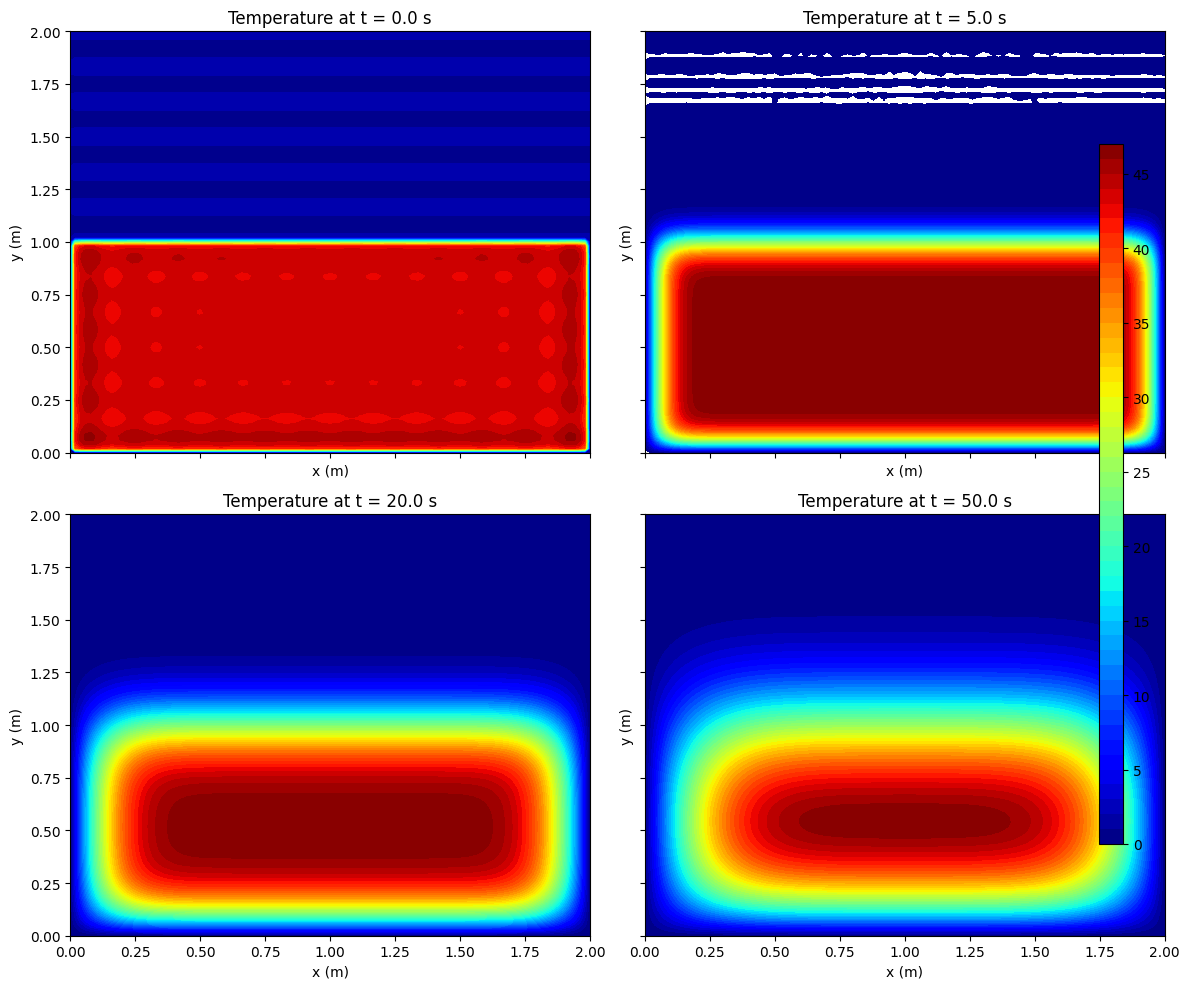

In [3]:
# . . Your answer to Q1-1 goes here
# Constants
nx= 101
ny= 101
x= np.linspace(0, 2, nx)  # x-coordinates
y= np.linspace(0, 2, ny)  # y-coordinates
X, Y= np.meshgrid(x, y)  # Create a meshgrid
K= 6.25e-4  # Thermal conductivity in m^2/s
# Time values
times = [0.0, 5.0, 20.0, 50.0]
T_A_values = []

# Summation limits
M = 175
N = 175

# Compute T_A for each time
for t in times:
    T_A = np.zeros_like(X)
    for m in range(1, M + 1): #boundary is all zero
        for n in range(1, N + 1):
            # Compute the individual term
            term = (1 + (-1) ** (m + 1)) * (1 - np.cos(n * np.pi / 2)) / (m * n)
            T_A += term * np.sin(m * np.pi * X / 2) * np.sin(n * np.pi * Y / 2) * np.exp(-K * np.pi**2 * (m**2 + n**2) * t / 4)
    T_A_values.append((200 / np.pi**2) * T_A)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Colorbar position

# Create the subplots
for ax, T_A, t in zip(axs.flatten(), T_A_values, times):
    c = ax.contourf(X, Y, T_A, levels=50, cmap='jet')
    ax.set_title(f'Temperature at t = {t} s')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

# Add colorbar
fig.colorbar(c, cax=cbar_ax)
plt.tight_layout()
plt.show()


**Q1-2:** Let's start with the grid sampled at $\Delta x = \Delta y = 0.02$m and using a time step of $\Delta t = 0.05$s.  Generate your 2D numerical solution for this problem using the 2D Crank-Nicholson solution approach developed at the end of the  notebook. To illustrate your numerical solution, develop an animation showing: (1) the analytic solution $T_A$, (2) the numerical solution at the current solution step (i.e., $T^n_{i,j}$), and (3) the difference between the analytic and numerical solutions at the current solution step (i.e., $T_A-T^n_{i,j}$). If you are unable to generate an animation, please include illustrative plots to show the solution.

In [4]:
def Solver_1(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB):
    '''Set up tridiagonal matrix and call Thomas Algorithm
    usage: x = Solve_2D_Convection_Diffusion_homogeneous_Thomas(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB):
    input:
        U: heat solution at time step n   (nx)
        K : thermal diffusivity
        vx: convection velocity in x-direction
        vy: convection velocity in y-direction
        dx: spatial sampling in x-direction
        dy: spatial sampling in y-direction
        dt: temporal sampling
        LB: Left   boundary condition (Dirchelet)
        RB: Right  boundary condition (Dirchelet)
        BB: Bottom boundary condition (Dirchelet)
        TB: Top    boundary condition (Dirchelet)
    output:
        u: heat solution at time step n+1 (nx,ny)
    depends on:
        TDMAsolver

    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    ## . . Get dimensions
    nx,ny = np.size(U,0),np.size(U,1)
    U1 = np.zeros((nx,ny))

    ## Enforce boundary condition
    U[0,:] = TB
    U[-1,:] = BB
    U[:,0] = LB
    U[:,-1] = RB

    U1[0,:] = TB
    U1[-1,:] = BB
    U1[:,0] = LB
    U1[:,-1] = RB

    ## . . Define diffusivity and Courant numbers
    AX = K *dt/(dx*dx) ## Diffusivity x: alpha
    AY = K *dt/(dy*dy) ## Diffusivity y: alpha
    CX = vx*dt/ dx     ## Courant x : C
    CY = vy*dt/ dy     ## Courant y : C

    ## . . Set up coefficients in X
    ax =-(CX+2*AX)*np.ones(nx-2)
    bx =  4*(1+AX)*np.ones(nx-2)
    cx = (CX-2*AX)*np.ones(nx-2)

    ## . . Set up coefficients in Y
    ay =-(CY+2*AY)*np.ones(ny-2)
    by =  4*(1+AY)*np.ones(ny-2)
    cy = (CY-2*AY)*np.ones(ny-2)

    ## . . Treat ends
#     ax[0]=cx[nx-1]=ay[0]=cy[ny-1]=0

    ## . . Set up known Solution matrix
    dx = np.zeros((nx-2))
    dy = np.zeros((ny-2))

    ## . . Solve first for update in x direction
    for iy in range(1,ny-1):
        dx[:] =  -(CY-2*AY)*U[1:nx-1,iy+1]+\
                   4*(1-AY)*U[1:nx-1,iy  ]+\
                 +(CY+2*AY)*U[1:nx-1,iy-1]

        dx[0   ]+=+(CY+2*AY)*U[0   ,iy]
        dx[nx-3]+=-(CY-2*AY)*U[nx-1,iy]

        U1[1:nx-1,iy] = TDMAsolver(ax, bx, cx, dx)

    ## . . Solve second for update in yu direction
    for ix in range(1,nx-1):
        dy[:] =  -(CX-2*AX)*U1[ix+1,1:ny-1]+\
                   4*(1-AX)*U1[ix  ,1:ny-1]+\
                 +(CX+2*AX)*U1[ix-1,1:ny-1]

        dy[0   ]+=+(CX+2*AX)*U[ix,0   ]
        dy[ny-3]+=-(CX-2*AX)*U[ix,ny-1]

        U[ix,1:ny-1] = TDMAsolver(ay, by, cy, dy)

    return U

In [5]:
## . . Your answer to Q1-2 goes here
dx, dy= 0.02, 0.02
K= 6.25e-4  # Thermal conductivity in m^2/s
x= np.arange(0, 2+dx, dx)
y= np.arange(0, 2+dy, dy)
nx, ny= len(x), len(y)
X, Y= np.meshgrid(x, y)  # Create a meshgrid
nt,dt=401, 0.05
U= np.zeros((nx, ny))
LB=RB=BB=TB=0
vx, vy= 0,0 #should be zero
p2d= np.zeros((nx, ny, nt))
#Initial Condition
U[Y<1]= 50
U[Y==1]= 25
U[Y>1]= 0 #to be safe
# #check IC
# plt.figure()
# plt.imshow(U,cmap='jet', origin="lower", extent=[0,2,0,2])
# plt.xlabel('X (m)',fontsize=16);plt.ylabel('Y (m)',fontsize=16);
# plt.title('2D Initial Condition',fontsize=20)
# plt.colorbar()
# plt.show()


#solution finder
for i in range(nt):
    U = Solver_1(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB)
    p2d[:,:,i]=U

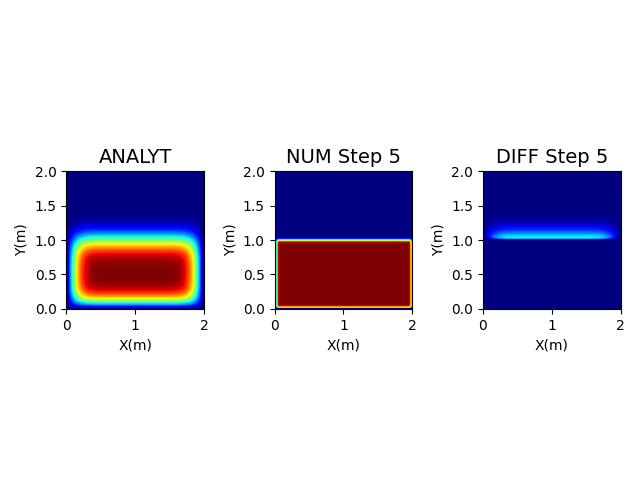

In [6]:
#animator
xmin,xmax,ymin,ymax=0,2,0,2
#real solution for t=20
TA= T_A_values[2]
## . . Set up movie
fig1,ax1 = plt.subplots(1,3)
fig1.subplots_adjust(0.1,0.1,0.9,0.9)
fig1.set_dpi(100)

def animate1(i):
    global k
    x = p2d[:,:,k]
    vmin,vmax = np.min(TA),np.max(TA)
    ax1[0].imshow(TA,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax1[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax1[0].set_title('ANALYT',fontsize=14)
    ax1[1].imshow(x ,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax1[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax1[1].set_title('NUM Step %s'%k,fontsize=14)
    ax1[2].imshow(TA-x ,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax1[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax1[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()


## . . Animate solution
k = 0
kskip = 5
## . . Call the animator.
ani_filename = 'Ex1.gif'
anim1 = animation.FuncAnimation(fig1,animate1,frames=int((nt-2*kskip)/kskip),interval=100)
anim1.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

**Q1-3:** An important question is **how does the choice of time discretization $\Delta t$ affect the accuracy and of the numerical solution**?  Illustrate the difference by redoing question **Q1-2** using 2x the number of time steps at one-half the time sampling (i.e., $\Delta t/2$).  Produce one figure illustrating your numerical solution like you did in **Q1-2**.

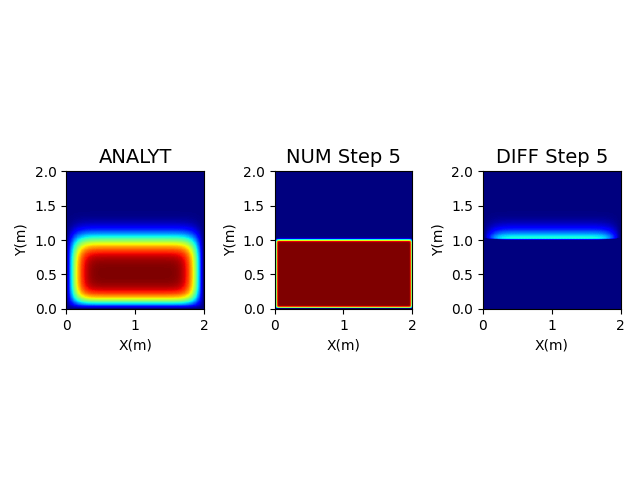

In [7]:
dx, dy= 0.02, 0.02
K= 6.25e-4  # Thermal conductivity in m^2/s
x= np.arange(0, 2+dx, dx)
y= np.arange(0, 2+dy, dy)
nx, ny= len(x), len(y)
X, Y= np.meshgrid(x, y)  # Create a meshgrid
nt,dt=801, 0.05/2 #need to change nt too
U= np.zeros((nx, ny))
LB=RB=BB=TB=0
vx, vy= 0,0 #should be zero
p2d= np.zeros((nx, ny, nt))
#Initial Condition
U[Y<1]= 50
U[Y==1]= 25
U[Y>1]= 0 #to be safe
# #check IC
# plt.figure()
# plt.imshow(U,cmap='jet', origin="lower", extent=[0,2,0,2])
# plt.xlabel('X (m)',fontsize=16);plt.ylabel('Y (m)',fontsize=16);
# plt.title('2D Initial Condition',fontsize=20)
# plt.colorbar()
# plt.show()


#solution finder
for i in range(nt):
    U = Solver_1(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB)
    p2d[:,:,i]=U

#animator
xmin,xmax,ymin,ymax=0,2,0,2
#real solution for t=20
TA= T_A_values[2]
## . . Set up movie
fig2,ax2 = plt.subplots(1,3)
fig2.subplots_adjust(0.1,0.1,0.9,0.9)
fig2.set_dpi(100)

def animate2(i):
    global k
    x = p2d[:,:,k]
    vmin,vmax = np.min(TA),np.max(TA)
    ax2[0].imshow(TA,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax2[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax2[0].set_title('ANALYT',fontsize=14)
    ax2[1].imshow(x ,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax2[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax2[1].set_title('NUM Step %s'%k,fontsize=14)
    ax2[2].imshow(TA-x ,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax2[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax2[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()


## . . Animate solution
k = 0
kskip = 5
## . . Call the animator.
ani_filename = 'Ex2.gif'
anim2 = animation.FuncAnimation(fig2, animate2,frames=int((nt-2*kskip)/kskip),interval=100)
anim2.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

As the discretization gets smaller, it takes more steps/computations to reach our analytical solution. This makes sense as each consectutive call of our Crank-Nicholson function only moves our solution $0.025$ seconds forward in time versus $0.05$ seconds. Additionally, this means it takes longer for the difference to converge.

**Q1-4:** What happens if you let $\Delta t$ get too large (e.g., $\Delta t=1.0$ s)?

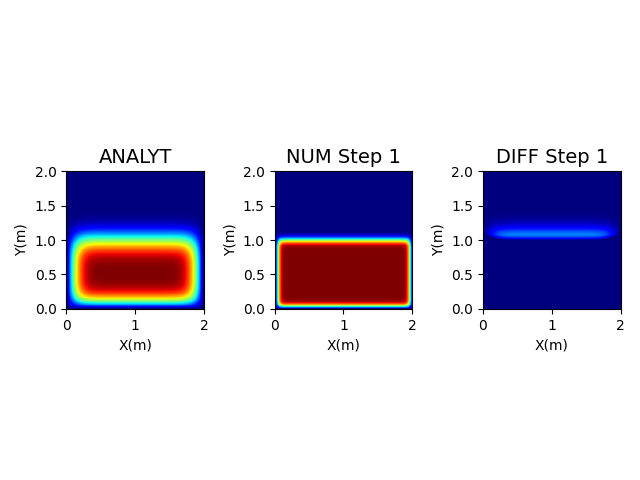

In [8]:
## . . Your answer to Q1-4 goes here
dx, dy= 0.02, 0.02
K= 6.25e-4  # Thermal conductivity in m^2/s
x= np.arange(0, 2+dx, dx)
y= np.arange(0, 2+dy, dy)
nx, ny= len(x), len(y)
X, Y= np.meshgrid(x, y)  # Create a meshgrid
nt,dt=51, 1.0
U= np.zeros((nx, ny))
LB=RB=BB=TB=0
vx, vy= 0,0 #should be zero
p2d= np.zeros((nx, ny, nt))
#Initial Condition
U[Y<1]= 50
U[Y==1]= 25
U[Y>1]= 0 #to be safe
# #check IC
# plt.figure()
# plt.imshow(U,cmap='jet', origin="lower", extent=[0,2,0,2])
# plt.xlabel('X (m)',fontsize=16);plt.ylabel('Y (m)',fontsize=16);
# plt.title('2D Initial Condition',fontsize=20)
# plt.colorbar()
# plt.show()


#solution finder
for i in range(nt):
    U = Solver_1(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB)
    p2d[:,:,i]=U

#animator
xmin,xmax,ymin,ymax=0,2,0,2
#real solution for t=20
TA= T_A_values[2]
## . . Set up movie
fig3,ax3 = plt.subplots(1,3)
fig3.subplots_adjust(0.1,0.1,0.9,0.9)
fig3.set_dpi(100)

def animate3(i):
    global k
    x = p2d[:,:,k]
    vmin,vmax = np.min(TA),np.max(TA)
    ax3[0].imshow(TA,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax3[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax3[0].set_title('ANALYT',fontsize=14)
    ax3[1].imshow(x ,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax3[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax3[1].set_title('NUM Step %s'%k,fontsize=14)
    ax3[2].imshow(TA-x ,cmap='jet', origin="lower",extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax3[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax3[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()


## . . Animate solution
k = 0
kskip = 1
## . . Call the animator.
ani_filename = 'Ex3.gif'
anim3 = animation.FuncAnimation(fig3,animate3,frames=int((nt-2*kskip)/kskip),interval=100)
anim3.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

If $\Delta t$ is too large than our solution converges too quickly, and we are unable to analyze the behavior of our solver. I am having a difficult time seeing if the error changes significantly given the three $\Delta t$ used. Visually, it looks similar, and just has different convergence times. Note, in the animation above it should have only ran for $20$ time steps, but I wanted to see what happens if I went further, and also we can analyze the behvaior a little better.

## Part 2 - Modeling Contaminant Transport

We are now going to come up with a basic modeling of contaminant transport phenomena where a pipe of radius $1$ m is discharging a contaminant with diffusivity of $K=6.25\times10^{-3}$ in water at rate of $C_0$ into a slow-moving river flowing at ${\bf v} = [v_x,v_y]=[0.004,0.004]$ m/s. For the purposes of this simulation, let's say that the river is 100 m wide and we are looking to model 100 m of its length.  The pipe is located at $[x_0,y_0]=[10,10]$ m which leads to the following forcing function

$$F(x,y) = C_0\delta(x-10)\delta(y-10)$$   

Given this setup, the problem we are trying to solve is given by the following **PDE**:

$$\frac{\partial \phi}{\partial t} +
v_x\frac{\partial \phi}{\partial x} +
v_y\frac{\partial \phi}{\partial y}
=  
\frac{\partial }{\partial x}\left(\kappa \frac{\partial \phi}{\partial x}\right)+
\frac{\partial }{\partial y}\left(\kappa \frac{\partial \phi}{\partial y}\right) +F(x,y).$$

for $x\in[0,100]$ m and $y\in[0,100]$ m with the following **Dirichlet boundary conditions** (in meters):

${\rm BOTTOM:} \quad\quad f(x,y=0 ) = 0$

${\rm TOP:}\quad\quad\quad\quad f(x,y=100) = 0$

${\rm LEFT:}\quad\quad\quad\,\, f(x=0,y) =   0$

${\rm RIGHT:}\quad\quad\,\,\,\, f(x=100,y) = 0$

Let's assume that for the **initial condition** that there is zero pollutant concentration such that

$$T(x,y,t=0) = 0$$

**Q2-1:** Let's first start with a grid sampled at $\Delta x = \Delta y = 1$ m and assume that $C_0=1$. Generate a 2D numerical solution for this problem using the 2D Crank-Nicholson solution approach developed at the end of the *09_Parabolic_PDEs.ipynb* notebook for the **first 6 hours of pollution**. Illustrate your numerical solution with an animation.  Choose a $\Delta t$ that provides a reasonably smooth animation. (I chose a $\Delta t$ between 5-60s.)

In [9]:
def Solve_Forcing(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB, F):
    '''Set up tridiagonal matrix and call Thomas Algorithm
    usage: x = Solve_2D_Convection_Diffusion_homogeneous_Thomas(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB):
    input:
        U: heat solution at time step n   (nx)
        K : thermal diffusivity
        vx: convection velocity in x-direction
        vy: convection velocity in y-direction
        dx: spatial sampling in x-direction
        dy: spatial sampling in y-direction
        dt: temporal sampling
        LB: Left   boundary condition (Dirchelet)
        RB: Right  boundary condition (Dirchelet)
        BB: Bottom boundary condition (Dirchelet)
        TB: Top    boundary condition (Dirchelet)
    output:
        u: heat solution at time step n+1 (nx,ny)
    depends on:
        TDMAsolver

    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    Edited by Anastasia Horne to account for forcing
    '''
    ## . . Get dimensions
    nx,ny = np.size(U,0),np.size(U,1)
    U1 = np.zeros((nx,ny))

    ## Enforce boundary condition
    U[0,:] = TB
    U[-1,:] = BB
    U[:,0] = LB
    U[:,-1] = RB

    U1[0,:] = TB
    U1[-1,:] = BB
    U1[:,0] = LB
    U1[:,-1] = RB

    ## . . Define diffusivity and Courant numbers
    AX = K *dt/(dx*dx) ## Diffusivity x: alpha
    AY = K *dt/(dy*dy) ## Diffusivity y: alpha
    CX = vx*dt/ dx     ## Courant x : C
    CY = vy*dt/ dy     ## Courant y : C

    ## . . Set up coefficients in X
    ax =-(CX+2*AX)*np.ones(nx-2)
    bx =  4*(1+AX)*np.ones(nx-2)
    cx = (CX-2*AX)*np.ones(nx-2)

    ## . . Set up coefficients in Y
    ay =-(CY+2*AY)*np.ones(ny-2)
    by =  4*(1+AY)*np.ones(ny-2)
    cy = (CY-2*AY)*np.ones(ny-2)

    ## . . Treat ends
#     ax[0]=cx[nx-1]=ay[0]=cy[ny-1]=0

    ## . . Set up known Solution matrix
    dx = np.zeros((nx-2))
    dy = np.zeros((ny-2))

    ## . . Solve first for update in x direction
    for iy in range(1,ny-1):
        dx[:] =  -(CY-2*AY)*U[1:nx-1,iy+1]+\
                   4*(1-AY)*U[1:nx-1,iy  ]+\
                 +(CY+2*AY)*U[1:nx-1,iy-1] + F[1:nx-1, iy]*2*dt

        dx[0   ]+=+(CY+2*AY)*U[0   ,iy]
        dx[nx-3]+=-(CY-2*AY)*U[nx-1,iy]

        U1[1:nx-1,iy] = TDMAsolver(ax, bx, cx, dx)

    ## . . Solve second for update in yu direction
    for ix in range(1,nx-1):
        dy[:] =  -(CX-2*AX)*U1[ix+1,1:ny-1]+\
                   4*(1-AX)*U1[ix  ,1:ny-1]+\
                 +(CX+2*AX)*U1[ix-1,1:ny-1] + F[ix, 1:ny-1]*2*dt

        dy[0   ]+=+(CX+2*AX)*U[ix,0   ]
        dy[ny-3]+=-(CX-2*AX)*U[ix,ny-1]

        U[ix,1:ny-1] = TDMAsolver(ay, by, cy, dy)

    return U

In [10]:
## . . Your solution to Q2-1 goes here
vx, vy= 0.004, 0.004
xmin, xmax, ymin, ymax= 0, 100, 0, 100
nx, ny= 101, 101
dx, dy= 1,1
x= np.arange(0, 100+dx, dx)
y= np.arange(0, 100+dy, dy)

C0=1
K= 6.25e-3
nt, dt= 720, 30
LB=RB=BB=TB=0

#set up forcing term
F = np.zeros((nx, ny))
F[10, 10] = C0

## . . Solution space
p2d = np.zeros((nx,ny,nt))
U= np.zeros((nx, ny))
## . . Loop over time
for i in range(nt):
    U = Solve_Forcing(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB, F)
    p2d[:,:,i]=U


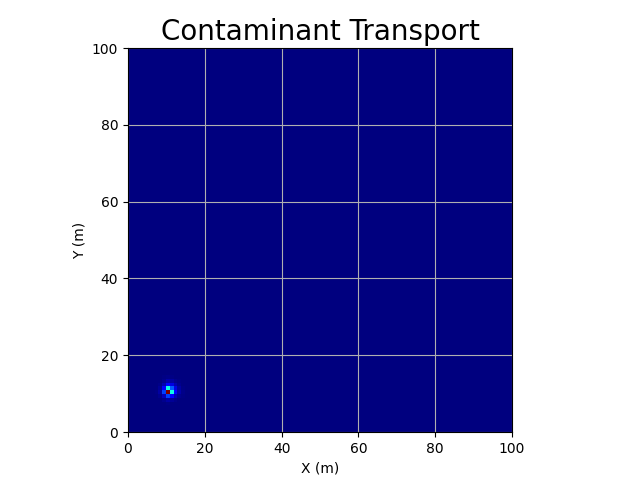

In [11]:
#animate
def animate4(i):
    global k
    ax4.clear()
    ax4.imshow(p2d[:,:,k],cmap='jet',origin="lower", extent=[xmin,xmax,ymin,ymax])
    ax4.grid(True)
    ax4.set(xlabel='X (m)',ylabel='Y (m)')
    ax4.set_title('Contaminant Transport',fontsize=20)
    k += kskip

## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig4,ax4 = plt.subplots(1)
fig4.subplots_adjust(0.1,0.1,0.9,0.9)
fig4.set_dpi(100)

## . . Call the animator.
ani_filename = 'Ex4.gif'
anim4 = animation.FuncAnimation(fig4,animate4,frames=int((nt-2*kskip)/kskip),interval=100)
anim4.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

## Part 3 - Incorporating a more complex stream velocity

You now want to model a more realistic stream velocity since having a constant stream throughout is not realistic. Your hydrologist friend suggests using the following stream function:

$${\bf v} = [v_x,v_y] = [(1+5e^{-(y-50)^2/400})/250,1/250]$$

**Q3-1:** Adapt your solution from Part 2 to incorporate this stream velocity function.  Note that this will require you to incorporate a spatially variable $v_x$ and $v_y$ function in your previous solver. The other components of your coding solution should largely be the same.

In [12]:
def Solve_Forcing_Vel(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB, F):
    '''Set up tridiagonal matrix and call Thomas Algorithm
    usage: x = Solve_2D_Convection_Diffusion_homogeneous_Thomas(U,K,vx,vy,dx,dy,dt,LB,RB,BB,TB):
    input:
        U: heat solution at time step n   (nx)
        K : thermal diffusivity
        vx: convection velocity in x-direction
        vy: convection velocity in y-direction
        dx: spatial sampling in x-direction
        dy: spatial sampling in y-direction
        dt: temporal sampling
        LB: Left   boundary condition (Dirchelet)
        RB: Right  boundary condition (Dirchelet)
        BB: Bottom boundary condition (Dirchelet)
        TB: Top    boundary condition (Dirchelet)
    output:
        u: heat solution at time step n+1 (nx,ny)
    depends on:
        TDMAsolver

    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    Edited by Anastasia Horne to account for forcing and varying velocity
    '''
    ## . . Get dimensions
    nx,ny = np.size(U,0),np.size(U,1)
    U1 = np.zeros((nx,ny))

    ## Enforce boundary condition
    U[0,:] = TB
    U[-1,:] = BB
    U[:,0] = LB
    U[:,-1] = RB

    U1[0,:] = TB
    U1[-1,:] = BB
    U1[:,0] = LB
    U1[:,-1] = RB

    ## . . Define diffusivity and Courant numbers
    AX = K *dt/(dx*dx) ## Diffusivity x: alpha
    AY = K *dt/(dy*dy) ## Diffusivity y: alpha
    CY = vy*dt/ dy     ## Courant y : C
    CX = vx*dt/ dx     ## Courant x : C

    ## . . Set up coefficients in X
    ax =-(CX[1:nx-1]+2*AX)*np.ones(nx-2)
    bx =  4*(1+AX)*np.ones(nx-2)
    cx = (CX[1:nx-1]-2*AX)*np.ones(nx-2)

    ## . . Set up coefficients in Y
    ay =-(CY+2*AY)*np.ones(ny-2)
    by =  4*(1+AY)*np.ones(ny-2)
    cy = (CY-2*AY)*np.ones(ny-2)

    ## . . Treat ends
#     ax[0]=cx[nx-1]=ay[0]=cy[ny-1]=0

    ## . . Set up known Solution matrix
    dx2 = np.zeros((nx-2))
    dy2 = np.zeros((ny-2))

    ## . . Solve first for update in x direction
    for iy in range(1,ny-1):
        dx2[:] =  -(CY-2*AY)*U[1:nx-1,iy+1]+\
                   4*(1-AY)*U[1:nx-1,iy  ]+\
                 +(CY+2*AY)*U[1:nx-1,iy-1] + F[1:nx-1, iy]*2*dt

        dx2[0   ]+=+(CY+2*AY)*U[0   ,iy]
        dx2[nx-3]+=-(CY-2*AY)*U[nx-1,iy]

        U1[1:nx-1,iy] = TDMAsolver(ax, bx, cx, dx2)

    ## . . Solve second for update in yu direction
    #we index CX based on y since v_x varies based on y
    for ix in range(1,nx-1):
      dy2[:] =  -(CX[1:ny-1]-2*AX)*U1[ix+1,1:ny-1]+\
                  4*(1-AX)*U1[ix  ,1:ny-1]+\
                +(CX[1:ny-1]+2*AX)*U1[ix-1,1:ny-1] + F[ix, 1:ny-1]*2*dt

      dy2[0   ]+=+(CX[0]+2*AX)*U[ix,0   ]
      dy2[ny-3]+=-(CX[ny-1]-2*AX)*U[ix,ny-1]

      U[ix,1:ny-1] = TDMAsolver(ay, by, cy, dy2)

    return U

In [13]:
## . . Your answer to Q3-1 goes here
from time import time
#NOTE: velocity is constant in y direction. So we only need a vector for v_x
vy= 1/250
xmin, xmax, ymin, ymax= 0, 100, 0, 100
nx, ny= 101, 101
dx, dy= 1,1
x= np.arange(0, 100+dx, dx)
y= np.arange(0, 100+dy, dy)
vx2= (1+5*np.exp(-((y-50)**2)/400)) /250

C0=1
K= 6.25e-3
nt, dt= 720, 30
LB=RB=BB=TB=0

#set up forcing term
F = np.zeros((nx, ny))
F[10, 10] = C0

## . . Solution space
p3d = np.zeros((nx,ny,nt))
U= np.zeros((nx, ny))
## . . Loop over time
for i in range(nt):
    start= time()
    U = Solve_Forcing_Vel(U,K,vx2, vy, dx,dy,dt,LB,RB,BB,TB, F)
    end=time()
    p3d[:,:,i]=U

print("The total execution time for python:", end-start, "s")

The total execution time for python: 0.04909706115722656 s


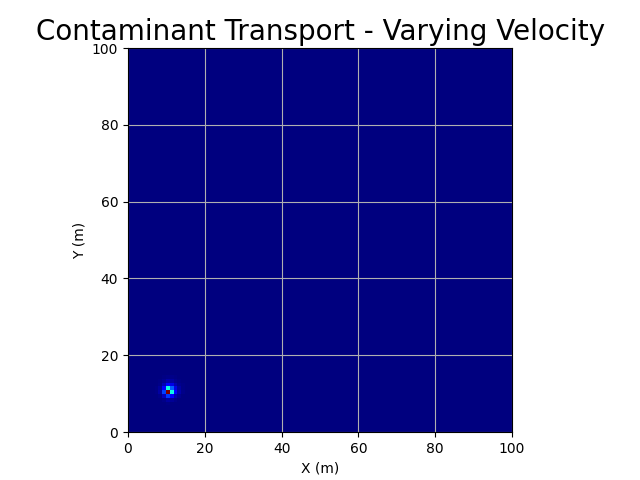

In [14]:
#animate
def animate5(i):
    global k
    ax5.clear()
    ax5.imshow(p3d[:,:,k],cmap='jet',origin="lower", extent=[xmin,xmax,ymin,ymax])
    ax5.grid(True)
    ax5.set(xlabel='X (m)',ylabel='Y (m)')
    ax5.set_title('Contaminant Transport - Varying Velocity',fontsize=20)
    k += kskip

## . . Animate solution
k = 0
kskip = 5

## . . Set up movie
fig5,ax5 = plt.subplots(1)
fig5.subplots_adjust(0.1,0.1,0.9,0.9)
fig5.set_dpi(100)

## . . Call the animator.
ani_filename = 'Ex5.gif'
anim5 = animation.FuncAnimation(fig5,animate5,frames=int((nt-2*kskip)/kskip),interval=100)
anim5.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

In [15]:
#shows that the end conditions are different, despite them looking similar
print("The difference between part 3 final solution and part 2 final solution:",np.sum(abs(p3d[:,:,35]-p2d[:,:,35])))

The difference between part 3 final solution and part 2 final solution: 88.94328075644641


# Part 4 (GPGN536 only) - Convert Part 3 code into C, verify the results using Python and compare the computational performance.

In [16]:
%%writefile Crank_Nicholson2_c.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

void TDMAsolver(double *a, double *b, double *c, double *d, double *xc, int nf) {
    double *bc = (double *)malloc(nf * sizeof(double));
    double *dc = (double *)malloc(nf * sizeof(double));

    for (int i = 0; i < nf; i++) {
        bc[i] = b[i];
        dc[i] = d[i];
    }

    // Forward sweep
    for (int it = 1; it < nf; it++) {
        double mc = a[it] / bc[it - 1];
        bc[it] = bc[it] - mc * c[it - 1]; // Overwriting b
        dc[it] = dc[it] - mc * dc[it - 1]; // Overwriting d
    }

    // Backsubstitution sweep
    xc[nf - 1] = dc[nf - 1] / bc[nf - 1];

    for (int il = nf - 2; il >= 0; il--) {
        xc[il] = (dc[il] - c[il] * xc[il + 1]) / bc[il];
    }

    free(bc);
    free(dc);
}

void Solve_2D_Convection_Diffusion_homogeneous_Thomas_Forcing_Vel(double **U, double K, double vx[], double vy, double dx, double dy, double dt, double LB, double RB, double BB, double TB, double **F, int nx, int ny) {
    double **U1 = (double **)malloc(nx * sizeof(double *));
    for (int i = 0; i < nx; i++) {
        U1[i] = (double *)malloc(ny * sizeof(double));
    }

    // Enforce boundary condition
    for (int j = 0; j < ny; j++) {
        U[0][j] = TB;
        U[nx - 1][j] = BB;
    }
    for (int i = 0; i < nx; i++) {
        U[i][0] = LB;
        U[i][ny - 1] = RB;
    }

    for (int j = 0; j < ny; j++) {
        U1[0][j] = TB;
        U1[nx - 1][j] = BB;
    }
    for (int i = 0; i < nx; i++) {
        U1[i][0] = LB;
        U1[i][ny - 1] = RB;
    }

    // Define diffusivity and Courant numbers
    double AX = K * dt / (dx * dx); // Diffusivity x: alpha
    double AY = K * dt / (dy * dy); // Diffusivity y: alpha
    double CY = vy * dt / dy;

    // Set up coefficients in Y
    double *ay = (double *)malloc((ny - 2) * sizeof(double));
    double *by = (double *)malloc((ny - 2) * sizeof(double));
    double *cy = (double *)malloc((ny - 2) * sizeof(double));

    for (int j = 0; j < ny - 2; j++) {
        ay[j] = -(CY + 2 * AY);
        by[j] = 4 * (1 + AY);
        cy[j] = (CY - 2 * AY);
    }

    double CX = vx[0] * dt / dx; // Courant x : C
    double *ax = (double *)malloc((nx - 2) * sizeof(double));
    double *bx = (double *)malloc((nx - 2) * sizeof(double));
    double *cx = (double *)malloc((nx - 2) * sizeof(double));

    for (int j = 0; j < nx - 2; j++) {
        ax[j] = -((vx[j+1] * dt / dx) + 2 * AX);
        bx[j] = 4 * (1 + AX);
        cx[j] = ((vx[j+1] * dt / dx) - 2 * AX);
    }

    // Set up known Solution matrix
    double *dx2 = (double *)malloc((nx - 2) * sizeof(double));
    double *dy2 = (double *)malloc((ny - 2) * sizeof(double));

    // Solve first for update in x direction
    for (int iy = 1; iy < ny - 1; iy++) {


        for (int j = 1; j < nx - 1; j++) {
            dx2[j - 1] = -(CY - 2 * AY) * U[j][iy + 1] +
                          4 * (1 - AY) * U[j][iy] +
                          (CY + 2 * AY) * U[j][iy - 1] + F[j][iy] * 2 * dt;
        }

        dx2[0] += (CY + 2 * AY) * U[0][iy];
        dx2[nx - 3] += -(CY - 2 * AY) * U[nx - 1][iy];

        double *xc = (double *)malloc((nx - 2) * sizeof(double));
        TDMAsolver(ax, bx, cx, dx2, xc, nx - 2);

        for (int j = 1; j < nx - 1; j++) {
            U1[j][iy] = xc[j - 1];
        }
        free(xc);
    }

    free(ax);
    free(bx);
    free(cx);

    // Solve second for update in y direction
    for (int ix = 1; ix < nx - 1; ix++) {
        for (int j = 1; j < ny - 1; j++) {
            dy2[j - 1] = -((vx[j] * dt / dx) - 2 * AX) * U1[ix + 1][j] +
                          4 * (1 - AX) * U1[ix][j] +
                          ((vx[j] * dt / dx) + 2 * AX) * U1[ix - 1][j] + F[ix][j] * 2 * dt;
        }

        dy2[0] += ((vx[0] * dt / dx) + 2 * AX) * U[ix][0];
        dy2[ny - 3] += -((vx[ny-1] * dt / dx) - 2 * AX) * U[ix][ny - 1];

        double *xc = (double *)malloc((ny - 2) * sizeof(double));
        TDMAsolver(ay, by, cy, dy2, xc, ny - 2);

        for (int j = 1; j < ny - 1; j++) {
            U[ix][j] = xc[j - 1];
        }

        free(xc);
    }

    for (int i = 0; i < nx; i++) {
        free(U1[i]);
    }
    free(U1);
    free(ay);
    free(by);
    free(cy);
    free(dx2);
    free(dy2);
}




int main() {
    // Constants
    double vy = 1.0 / 250.0;
    int nx = 101, ny = 101;
    double xmin = 0, xmax = 100, ymin = 0, ymax = 100;
    double dx = 1, dy = 1;
    double K = 6.25e-3;
    int nt = 720;
    double dt = 30;
    double LB = 0, RB = 0, BB = 0, TB = 0;

    // Allocate memory for velocity vector vx
    double *vx = (double *)malloc(ny * sizeof(double));
    double *y = (double *)malloc(ny * sizeof(double));

    // Initialize y values and compute vx
    for (int j = 0; j < ny; j++) {
        y[j] = j * dy;
        vx[j] = (1 + 5 * exp(-pow((y[j] - 50), 2) / 400)) / 250;
    }


    // Allocate memory for forcing term F
    double **F = (double **)malloc(nx * sizeof(double *));
    for (int i = 0; i < nx; i++) {
        F[i] = (double *)calloc(ny, sizeof(double));
    }
    F[10][10] = 1; // Set the forcing term

    // Allocate memory for the solution U and p3d
    double **U = (double **)malloc(nx * sizeof(double *));
    double **U1 = (double **)malloc(nx * sizeof(double *));
    double ***p3d = (double ***)malloc(nt * sizeof(double **));
    for (int i = 0; i < nx; i++) {
        U[i] = (double *)calloc(ny, sizeof(double));
        U1[i] = (double *)calloc(ny, sizeof(double));
    }
    for (int i = 0; i < nt; i++) {
        p3d[i] = (double **)malloc(nx * sizeof(double *));
        for (int j = 0; j < nx; j++) {
            p3d[i][j] = (double *)calloc(ny, sizeof(double));
        }
    }
    clock_t start, end;
    double cpu_time_used;

    // Time loop
    for (int i = 0; i < nt; i++) {
        start = clock();
        Solve_2D_Convection_Diffusion_homogeneous_Thomas_Forcing_Vel(
            U, K, vx, vy, dx, dy, dt, LB, RB, BB, TB, F, nx, ny
        );
        end = clock();
        cpu_time_used = ((double) (end - start)) / CLOCKS_PER_SEC;

        // Store the result in p3d
        for (int j = 0; j < nx; j++) {
            for (int k = 0; k < ny; k++) {
                p3d[i][j][k] = U[j][k];
            }
        }
    }

    printf("The total execution time for C: %f s\n", cpu_time_used);

    const char *filename = "solution.txt";
    FILE *file = fopen(filename, "w"); // Open for text writing
      if (file == NULL) {
        fprintf(stderr, "Error opening file for writing!\n");
        return EXIT_FAILURE;
      }

    // Write the dimensions and the matrix data
    fprintf(file, "%d %d\n", nx, ny);
    for (int i = 0; i < nx; i++) {
      for (int j = 0; j < ny; j++) {
        fprintf(file, "%lf ", p3d[nt-1][i][j]); // Writing the last time step
      }
    fprintf(file, "\n"); // New line after each row
    }

    fclose(file); // Close the file
    printf("Solution written to %s\n", filename);


    // Free allocated memory
    free(vx);
    free(y);
    for (int i = 0; i < nx; i++) {
        free(F[i]);
        free(U[i]);
        free(U1[i]);
    }
    free(F);
    free(U);
    free(U1);
    for (int i = 0; i < nt; i++) {
        for (int j = 0; j < nx; j++) {
            free(p3d[i][j]);
        }
        free(p3d[i]);
    }
    free(p3d);

    return 0;
}

Overwriting Crank_Nicholson2_c.c


In [17]:
%%shell
gcc -o Crank_Nicholson2_c Crank_Nicholson2_c.c -lm
./Crank_Nicholson2_c

The total execution time for C: 0.000794 s
Solution written to solution.txt


Text(0.5, 1.0, 'C Final Solution')

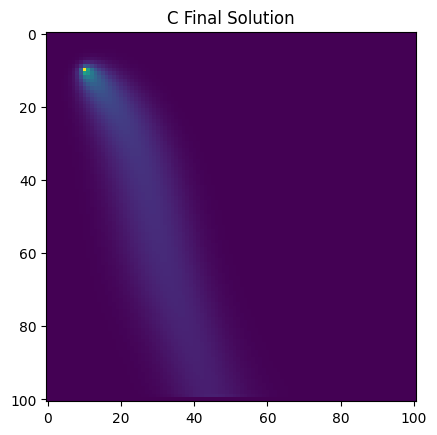

In [20]:
filename = "solution.txt"

# Open the file and read the matrix
with open(filename, 'r') as file:
    # Read dimensions
    rows, cols = map(int, file.readline().strip().split())

    # Initialize the matrix
    matrix = []

    # Read each row of the matrix
    for _ in range(rows):
        line = file.readline().strip()
        # Convert the line into a list of floats and append to matrix
        matrix.append(list(map(float, line.split())))

plt.imshow(matrix)
plt.title("C Final Solution")


Text(0.5, 1.0, 'Python Final Solution')

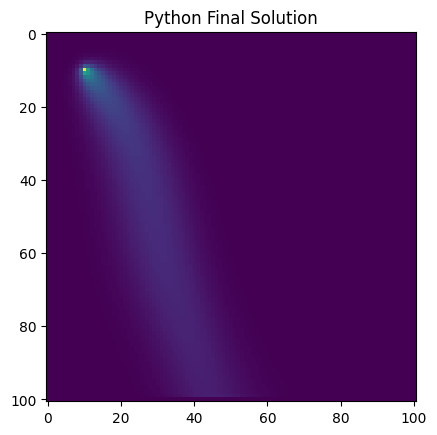

In [21]:
plt.imshow(p3d[:,:,719])
plt.title("Python Final Solution")

We see from the two above images that our C and python solutions are identical. Additionally the C solver performs faster than the python solver, as expected. The python code took hundreths of seconds to run, meanwhile the C code took thousandths of seconds to run.